In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.fft import fft, ifft
from scipy.signal import periodogram
import ordpy 
import statsmodels.api as sm
from scipy.signal import butter,filtfilt
from matplotlib.pyplot import figure
from os import listdir
from os.path import isfile, join
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm

In [2]:
#list all the data files and its path
files_first = []
onlyfiles = [f for f in listdir('../Data/first_session') if isfile(join('../Data/first_session', f))]
for i in range(len(onlyfiles)):
    path = '../Data/first_session/' + onlyfiles[i]
    files_first.append(path)
files_second = []
onlyfiles = [f for f in listdir('../Data/second_session') if isfile(join('../Data/second_session', f))]
for i in range(len(onlyfiles)):
    path = '../Data/second_session/' + onlyfiles[i]
    files_second.append(path)
files_third = []
onlyfiles = [f for f in listdir('../Data/third_session') if isfile(join('../Data/third_session', f))]
for i in range(len(onlyfiles)):
    path = '../Data/third_session/' + onlyfiles[i]
    files_third.append(path)
files = []
files.append(files_first)
files.append(files_second)
files.append(files_third)
files


[['../Data/first_session/154625_painpred_2023-03-02_15h30.52.830.csv',
  '../Data/first_session/187074_painpred_03-02-2023_17h27.20.801.csv'],
 ['../Data/second_session/653852_painpred_2023-03-03_13h39.27.412.csv',
  '../Data/second_session/813637_painpred_2023-03-03_15h20.11.646.csv'],
 ['../Data/third_session/825459_painpred_2023-03-04_13h41.03.137.csv',
  '../Data/third_session/886054_painpred_2023-03-04_15h18.38.664.csv']]

# Preprocessing Functions
For windowing, I realise the reaction time is always the longest in the first trial. So I think we could window more (start from 6 seconds) for the first trial?

In [3]:

def window_value(rating, time): #use values instead of timing to window
    rating_windowed_list = []
    time_windowed_list = []
    failed_index_list = [] #capture error in data logging
    #window the trials by finding the first time that they have changed their rating
    for i in range(len(rating)):
        if len(rating) > 1: #catch the whole entry being NaN
            #catch nan, catch hitting middle of confidence slider, catch ending time
            #i.e. this condidtion is it taps on the middle of the confidence slider
            if len(rating[i]) > 1 and time[i][0] < 0.1 and time[i][-1] > 10:
                res_unchanged = next(x for x, val in enumerate(rating[i]) if val != rating[i][0])
                rating_windowed = rating[i][res_unchanged:len(rating[i])]
                time_windowed = time[i][res_unchanged:len(rating[i])]
                #replace trials with error in data logging with nan
                #for trials that has a very long reaction time (about 10 seconds), filter it away
                if time_windowed[0] < 10 and len(time_windowed) > 100:
                    rating_windowed_list.append(rating_windowed)
                    time_windowed_list.append(time_windowed)
                else:
                    rating_windowed_list.append([np.NaN])
                    time_windowed_list.append([np.NaN])
                    failed_index_list.append(i)
            #condition: no nan but tap on the slider (0.1s being the reaction time)
            elif len(rating[i]) > 1 and time[i][0] > 0.1 and time[i][-1] > 10:
                rating_windowed = rating[i] #don't window as it starts recording only when click the slider
                time_windowed = time[i]
                if time_windowed[0] < 10 and len(time_windowed) > 100:
                    rating_windowed_list.append(rating_windowed)
                    time_windowed_list.append(time_windowed)
                else:
                    rating_windowed_list.append([np.NaN])
                    time_windowed_list.append([np.NaN])
                    failed_index_list.append(i)
            else:
                rating_windowed_list.append([np.NaN])
                time_windowed_list.append([np.NaN])
                failed_index_list.append(i)
        else:
            rating_windowed_list.append([np.NaN])
            time_windowed_list.append([np.NaN])


    
        
    return rating_windowed_list, time_windowed_list, failed_index_list

    

def lowpass_butter(rating, time, cutoff, order=5):
    lowpass_list = [] #list for all 30 trials
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            N = len(rating[i])
            T = time[i][-1]-time[i][0]
            fs = N/T
            nyq = fs*0.5
            normal_cutoff = cutoff / nyq
            b, a = butter(order, normal_cutoff, btype='low', analog=False)
            y = filtfilt(b, a, rating[i])
            lowpass_list.append(y)
        else:
            lowpass_list.append([np.NaN])
    return lowpass_list
        


def exponential_smoothing_trial(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def exponential_smoothing(rating, alpha):
    lowpass_list = [] #list of all 30 trials
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            result = [rating[i][0]] # first value is same as series
            for n in range(1, len(rating[i])):
                result.append(alpha * rating[i][n] + (1 - alpha) * result[n-1])
            lowpass_list.append(result)
        else:
            lowpass_list.append([np.nan])
    return lowpass_list


        
    

# Analysis Functions

In [4]:
#mean, mean square, root mean square, variance, standard deviation
def mean(rating):
    mean_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            mean_list.append(np.mean(rating[i]))
        else:
            mean_list.append(np.NaN)
    return mean_list

def mean_square(rating, time): #strength/average power of the signal
    mean_square_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            mean_square_list.append(np.sum(np.array(rating[i]) ** 2)/(max(time[i]) - min(time[i])))
        else:
            mean_square_list.append(np.NaN)
    return mean_square_list

def rms(mean_square_list):
    return np.sqrt(mean_square_list)

def variance(rating,time):
    variance_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            diff_mean_square_sum = np.sum((rating[i] - np.mean(rating[i]))**2)
            variance = diff_mean_square_sum/(max(time[i]) - min(time[i]))
            variance_list.append(variance)
        else:
            variance_list.append(np.NaN)
    return variance_list

def std(variance_list):
    return np.sqrt(variance_list)
  


#frequency np.fft

def fft_data(rating, time):
    fft_weights_list = []
    fft_freq_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            fft_weights = fft(rating[i])
            N = len(fft_weights)
            n = np.arange(N)
            T = time[i][-1]-time[i][0]
            fft_freq = n/T
            fft_weights_list.append(fft_weights)
            fft_freq_list.append(fft_freq)
        else:
            fft_weights_list.append([np.NaN])
            fft_freq_list.append([np.NaN])
    return fft_weights_list, fft_freq_list


#power-spectrum
def power_spectrum(rating,time):
    psd_freq_list = []
    psd_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            N = len(rating[i])
            T = time[i][-1]
            f, S = periodogram(rating[i], N/T, scaling = 'density')
            psd_freq_list.append(f)
            psd_list.append(S)
        else:
            psd_freq_list.append([np.NaN])
            psd_list.append([np.NaN])
    return psd_freq_list, psd_list


#permutation entropy - complexity
def permutation_entropy(rating):
    entropy_list = []
    stat_complexity_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            entropy, stat_complexity = ordpy.complexity_entropy(rating[i])
            entropy_list.append(entropy)
            stat_complexity_list.append(stat_complexity)
        else:
            entropy_list.append(np.NaN)
            stat_complexity_list.append(np.NaN)
    return entropy_list, stat_complexity_list

#autocorrelation
def autocorrelation(rating):
    acorr_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            acorr = sm.tsa.acf(rating[i], nlags = int(len(rating[i])))
            acorr_list.append(acorr)
        else:
            acorr_list.append([np.NaN])
    return acorr_list

#check stationarity
def adfuller_test(rating):
    adfuller_list = []
    stationary_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            result = adfuller(rating[i])
            adfuller_list.append(result)
            if result[1] <= 0.05:
                stationary_list.append(1)
            else:
                stationary_list.append(0)
        else:
            adfuller_list.append(np.nan)
            stationary_list.append(np.nan)
    labels = ['ADF Test Statistic','p-value','#Lags Used','#Observation Used']
    return adfuller_list, labels, stationary_list
    


In [9]:
participant_id_first = []
participant_id_second = []
participant_id_third = []
for i in range(len(files_first)):
    data = pd.read_csv(files_first[i])
    participant_id_first.append(data['participant'][0])
for i in range(len(files_second)):
    data = pd.read_csv(files_second[i])
    participant_id_second.append(data['participant'][0])
for i in range(len(files_third)):
    data = pd.read_csv(files_third[i])
    participant_id_third.append(data['participant'][0])
participant_id_first = sorted(participant_id_first)
participant_id_second = sorted(participant_id_second)
participant_id_third = sorted(participant_id_third)

In [58]:
participant_number = []
for i in range(3):
    participant_number.append([])
for i in range(len(participant_id_first)):
    participant_number[0].append(i)
for i in range(len(participant_id_second)):
    for j in range(len(participant_id_first)):
        if participant_id_second[i] == participant_id_first[j]:
            participant_number[1].append(participant_number[0][j])
for i in range(len(participant_id_third)):
    for j in range(len(participant_id_first)):
        if participant_id_second[i] == participant_id_first[j]:
            participant_number[2].append(participant_number[0][j])
participant_number
    

[[0, 1], [0, 1], [0, 1]]

# Put continuous pain data into correct form & visualise

  0%|          | 0/3 [00:00<?, ?it/s]

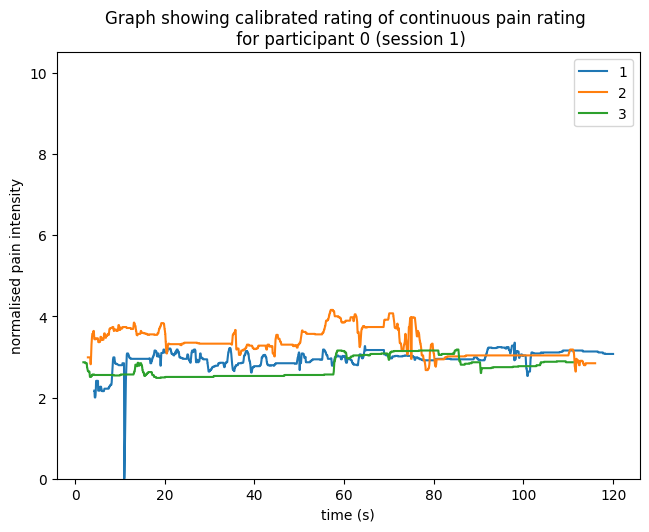

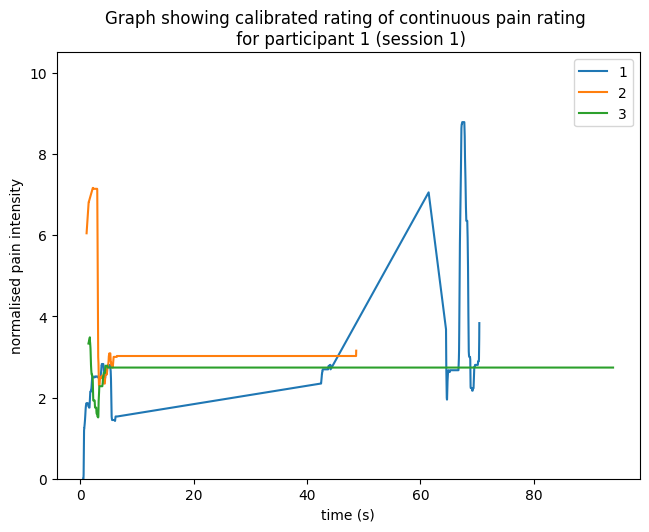

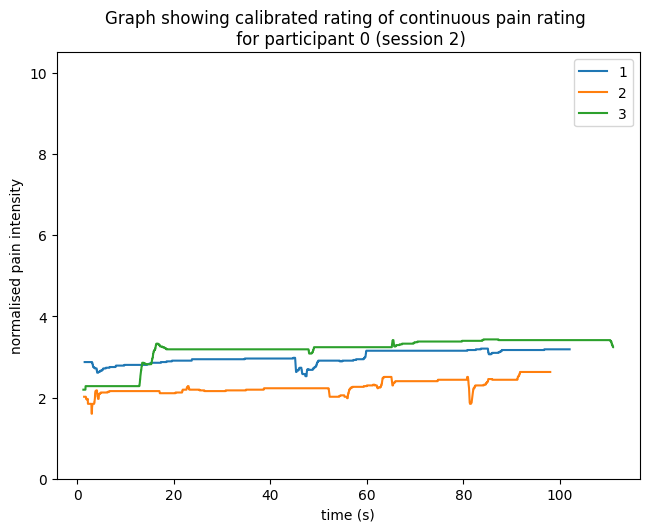

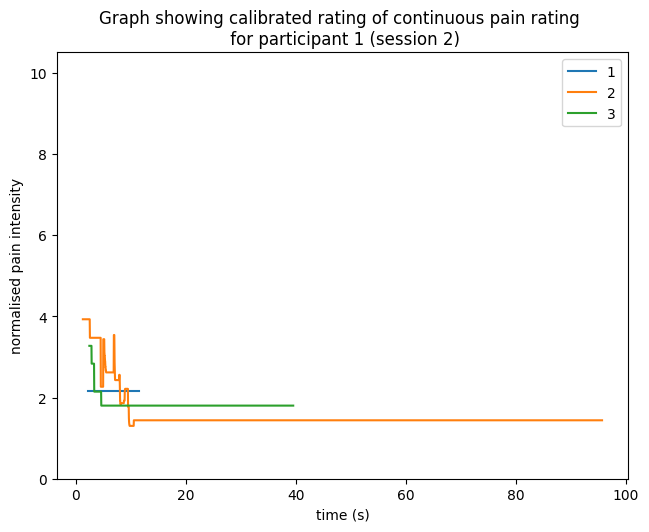

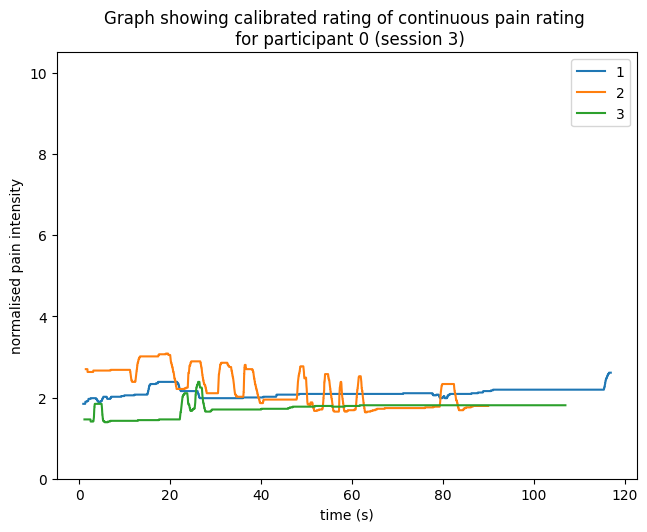

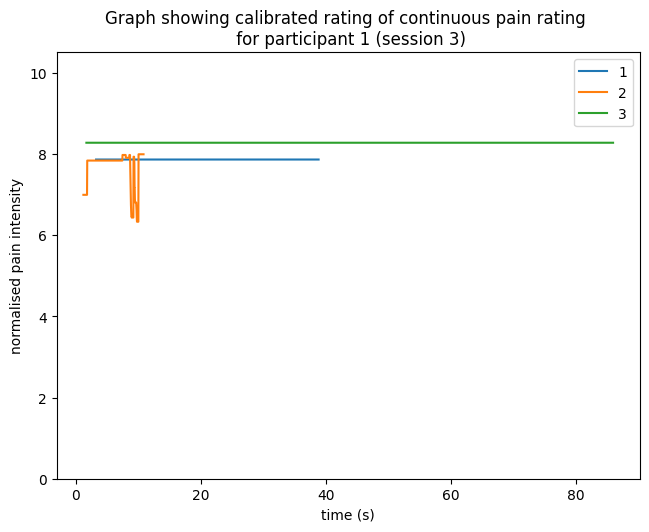

In [37]:
data_pos = [8,9,10,11]
sessions = [0,1,2]
mouse_slider_rating_list_all = []
mouse_slider_time_list_all = []
for session in tqdm(sessions):
    mouse_slider_rating_list_session = []
    mouse_slider_time_list_session = []
    for index in range(len(files[session])):
        plt.figure()
        data = pd.read_csv(files[session][index])

        #obtain relevant data

        #mouse_slider_data = data['mouse_slider.y'][len(data)-1-loops:len(data)-1]
        mouse_slider_data = []
        for j in data_pos:
            if type(data['mouse_slider.y'].iloc[j]) == str and len(data['mouse_slider.y'].iloc[j]) > 2:
                mouse_slider_data.append([float(data['mouse_slider.y'][j][1:-1].split(",")[i]) for i in range(len(data['mouse_slider.y'][j][1:-1].split(",")))])
            elif pd.isnull(data['mouse_slider.y'].iloc[j]):
                pass
            else:
                mouse_slider_data.append([np.nan])
        mouse_slider_time = data['mouse_slider.time']
        mouse_slider_time_data = []
        for j in data_pos:
            if type(data['mouse_slider.y'].iloc[j]) == str and len(data['mouse_slider.y'].iloc[j]) > 2:
                mouse_slider_time_data.append([float(data['mouse_slider.time'][j][1:-1].split(",")[i]) for i in range(len(data['mouse_slider.time'][j][1:-1].split(",")))])
            elif pd.isnull(data['mouse_slider.y'].iloc[j]):
                pass
            else:
                mouse_slider_time_data.append([np.nan])
            #calibration (normalise)
        mouse_slider_rating_list = []
        mouse_slider_time_list = []
        mouse_top_position = data['mouse_slider.top'][8]
        mouse_bottom_position = data['mouse_slider.bottom'][8]
        max_number = []
        min_number = []
            #note the beginning of the first train always starts from below the bottom of the slider due to the artefact from the position of the start button so when normalising we ignore the data of the artefact hence the data is a bit out of range
        for i in range(0,len(mouse_slider_data)):
            max_number.append(max(mouse_slider_data[i]))
            min_number.append(min(mouse_slider_data[i]))
        if max(max_number) > mouse_top_position:
            mouse_top_position = max(max_number)
        if min(min_number) < mouse_bottom_position:
            mouse_bottom_position = min(min_number)
        continuous_length = mouse_top_position - mouse_bottom_position

        for i in range(len(mouse_slider_data)):
            mouse_slider_data_np = np.array(mouse_slider_data[i])
            mouse_slider_time_np = np.array(mouse_slider_time_data[i])
            mouse_slider_time_list.append(mouse_slider_time_np)
            mouse_slider_rating = (mouse_slider_data_np - mouse_bottom_position)/continuous_length*10
            mouse_slider_rating_list.append(mouse_slider_rating)
        mouse_slider_rating_list_session.append(mouse_slider_rating_list)
        mouse_slider_time_list_session.append(mouse_slider_time_list)
    

            #plot
        for i in range(len(mouse_slider_data)):
            plt.plot(mouse_slider_time_list[i], mouse_slider_rating_list[i], label = i+1)
            plt.ylim(0,10.5)
            plt.legend()
        plt.tight_layout()
        plt.title(f'Graph showing calibrated rating of continuous pain rating \n for participant {participant_number[session][index]} (session {session+1})')
        plt.xlabel('time (s)')
        plt.ylabel('normalised pain intensity')
    mouse_slider_rating_list_all.append(mouse_slider_rating_list_session)
    mouse_slider_time_list_all.append(mouse_slider_time_list_session)
    




# Pre-process the data

In [45]:
#with the timing method
rating_windowed_list_all = []
time_windowed_list_all = []
lowpass_list_all = []
retained_participants_list = []

for session in sessions:
    rating_windowed_list_session = []
    time_windowed_list_session = []
    lowpass_list_session = []
    retained_participants_list_session = []
    for j in range(len(mouse_slider_rating_list_all[session])):
        rating_windowed_list, time_windowed_list, failed_index = window_value(mouse_slider_rating_list_all[session][j], mouse_slider_time_list_all[session][j])
        rating_windowed_list_session.append(rating_windowed_list)
        time_windowed_list_session.append(time_windowed_list)
        lowpass_list = exponential_smoothing(rating_windowed_list, alpha = 0.1)
        lowpass_list_session.append(lowpass_list)
        if len(failed_index) < 2:
            retained_participants_list_session.append(j)
    rating_windowed_list_all.append(rating_windowed_list_session)
    time_windowed_list_all.append(time_windowed_list_session)
    lowpass_list_all.append(lowpass_list_session)
    retained_participants_list.append(retained_participants_list_session)


    

## Plot smoothed data

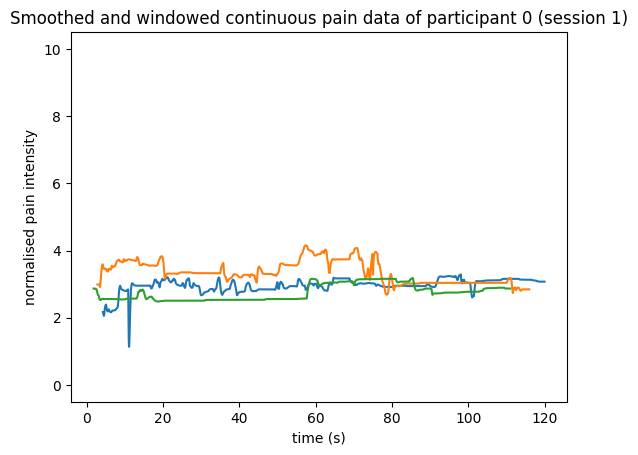

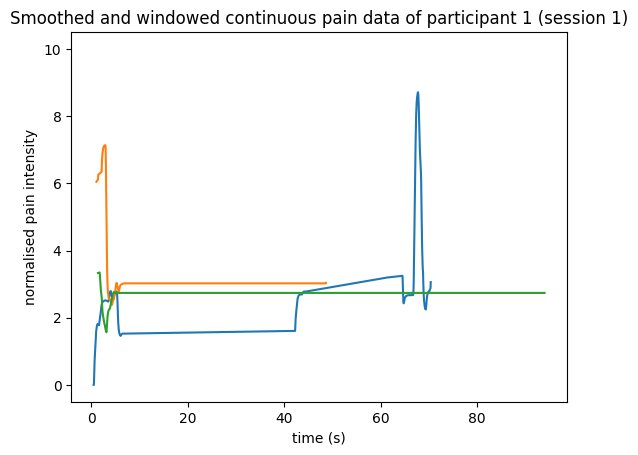

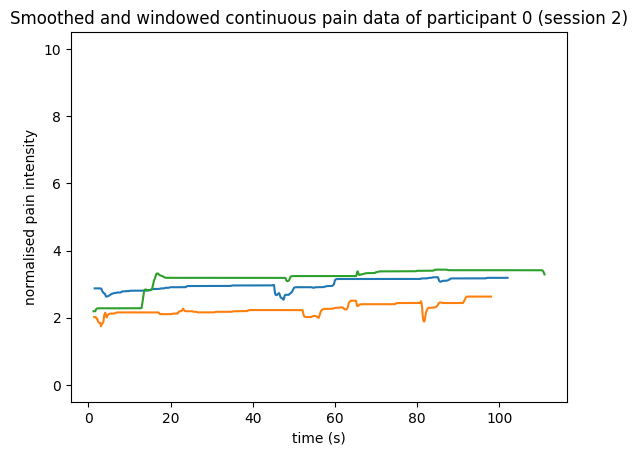

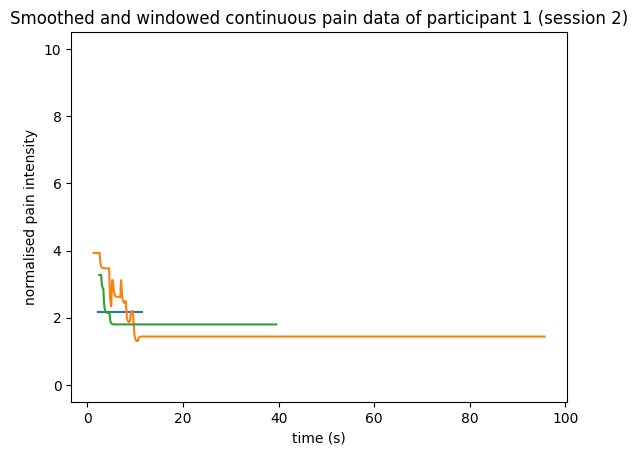

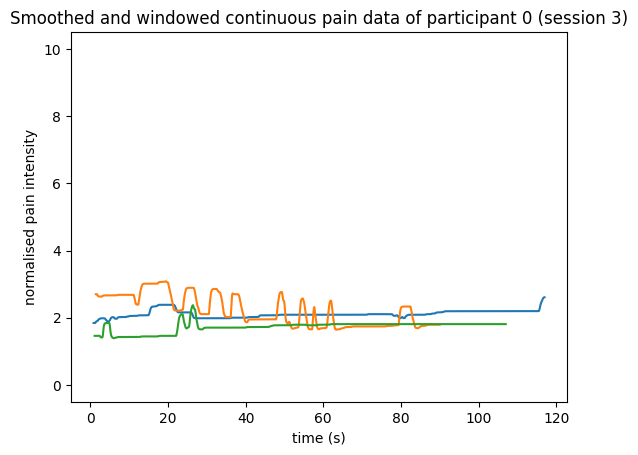

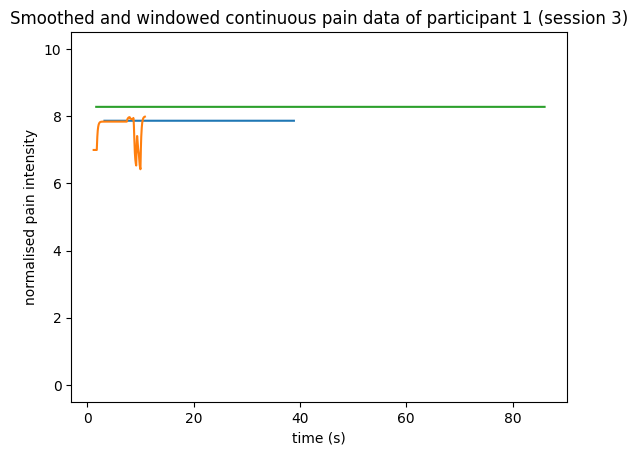

In [46]:
for session in sessions:
    for i in range(len(time_windowed_list_all[session])):
        if i in retained_participants_list[session]:
            plt.figure()
            for j in range(len(time_windowed_list_all[session][i])):
                plt.plot(time_windowed_list_all[session][i][j],lowpass_list_all[session][i][j])
                plt.ylabel('normalised pain intensity')
                plt.xlabel('time (s)')
                plt.ylim(-0.5,10.5)
                plt.title(f'Smoothed and windowed continuous pain data of participant {participant_number[session][i]} (session {session+1})')


# Analysis
## common statistical parameters

In [47]:
mean_list_all = []
mean_square_list_all = []
rms_list_all = []
variance_list_all = []
std_list_all = []
for session in sessions:
    mean_list_session = []
    mean_square_list_session = []
    rms_list_session = []
    variance_list_session = []
    std_list_session = []
    for j in range(len(lowpass_list_all[session])):
        if j in retained_participants_list[session]:
            mean_list = mean(lowpass_list_all[session][j])
            mean_square_list = mean_square(lowpass_list_all[session][j], time_windowed_list_all[session][j])
            rms_list = rms(mean_square_list)
            variance_list= variance(lowpass_list_all[session][j], time_windowed_list_all[session][j])
            std_list = std(variance_list)
            mean_list_session.append(mean_list)
            mean_square_list_session.append(mean_square_list)
            rms_list_session.append(rms_list)
            variance_list_session.append(variance_list)
            std_list_session.append(std_list)
        else:
            mean_list_all.append(np.nan)
            mean_square_list_all.append(np.nan)
            rms_list_all.append(np.nan)
            variance_list_all.append(np.nan)
            std_list_all.append(np.nan)
    mean_list_all.append(mean_list_session)
    mean_square_list_all.append(mean_square_list_session)
    rms_list_all.append(rms_list_session)
    variance_list_all.append(variance_list_session)
    std_list_all.append(std_list_session)


### Mean

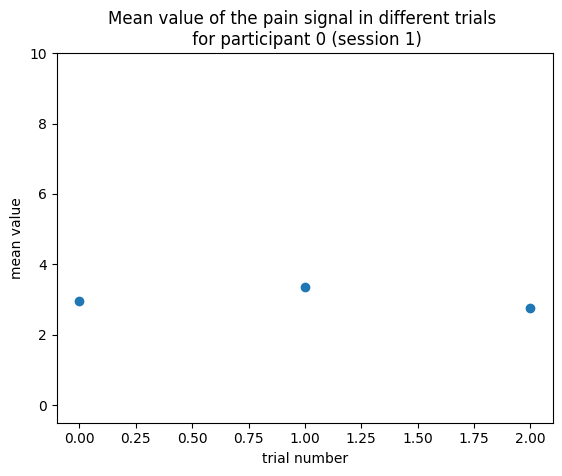

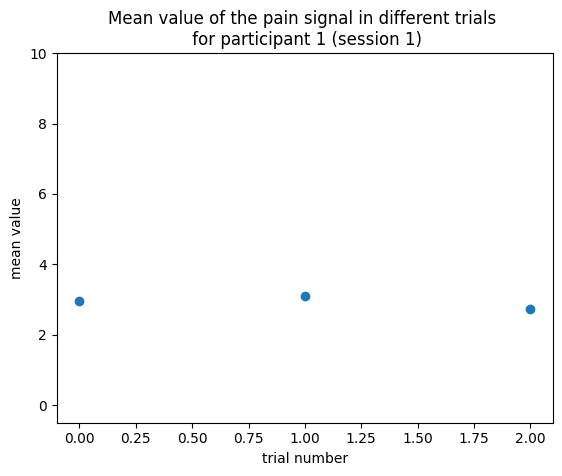

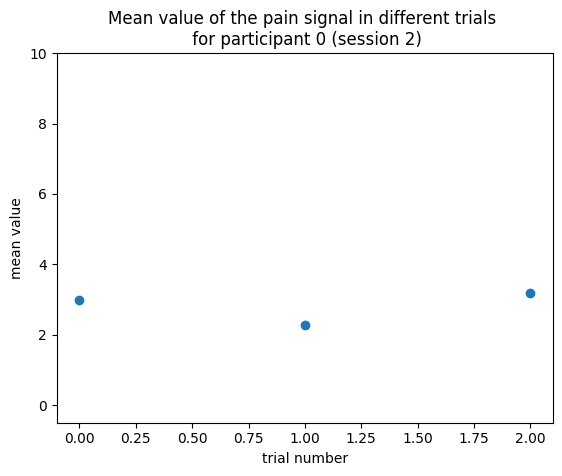

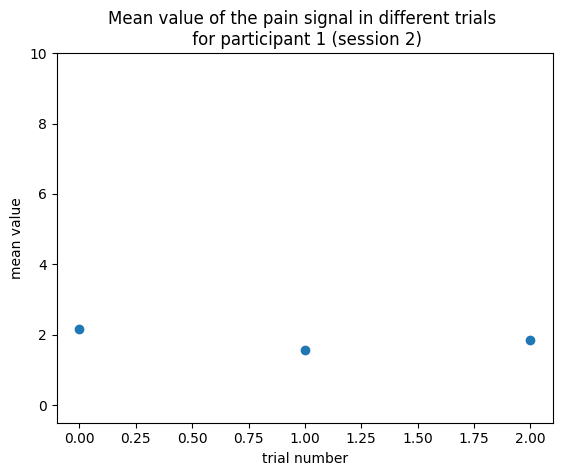

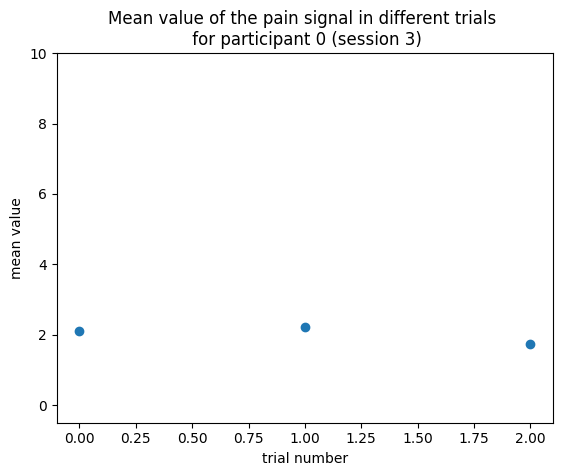

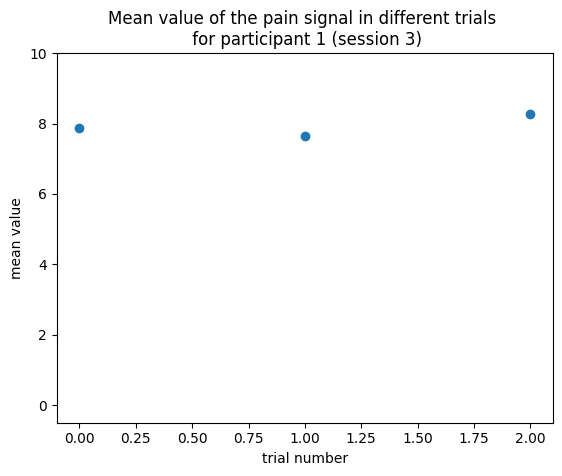

In [48]:
for session in sessions:
    for i in retained_participants_list[session]:
        plt.figure()
        plt.scatter(range(len(mean_list_all[session][i])), mean_list_all[session][i])
        plt.ylim(-0.5,10)
        plt.xlabel('trial number')
        plt.ylabel('mean value')
        plt.title(f'Mean value of the pain signal in different trials \n for participant {participant_number[session][i]} (session {session+1})')

### Mean square

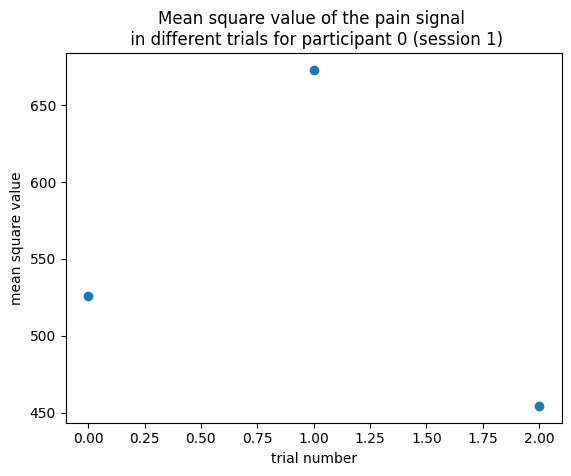

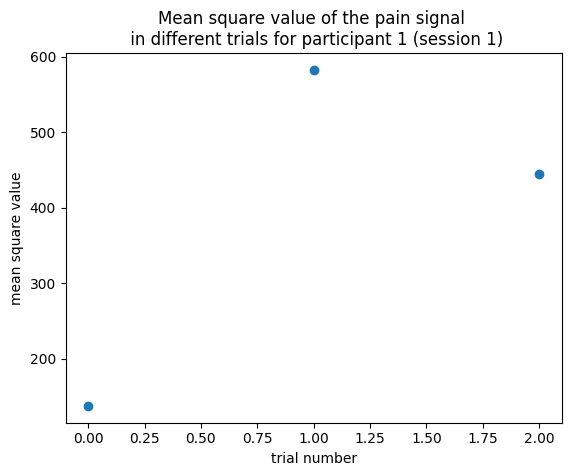

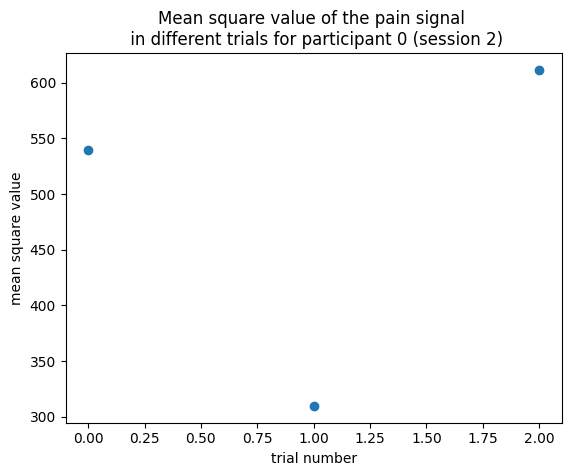

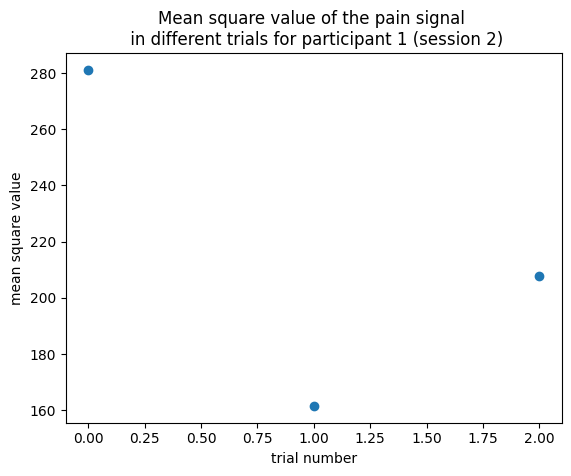

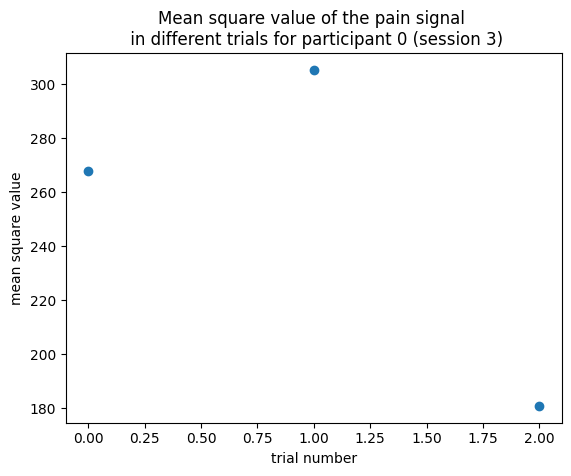

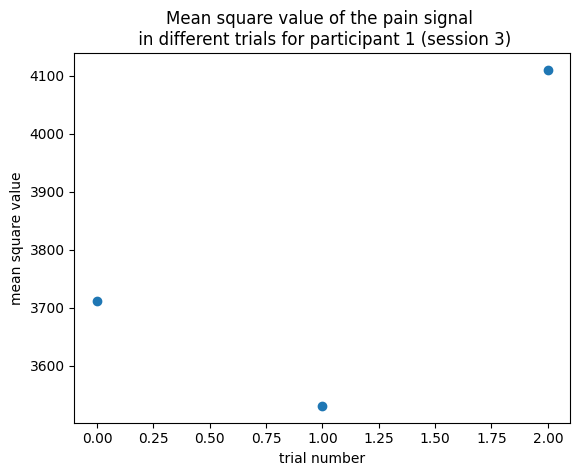

In [49]:
for session in sessions:
    for i in retained_participants_list[session]:
        plt.figure()
        plt.scatter(range(len(mean_square_list_all[session][i])), mean_square_list_all[session][i])
        plt.xlabel('trial number')
        plt.ylabel('mean square value')
        plt.title(f'Mean square value of the pain signal \n in different trials for participant {participant_number[session][i]} (session {session+1})')

### Variance

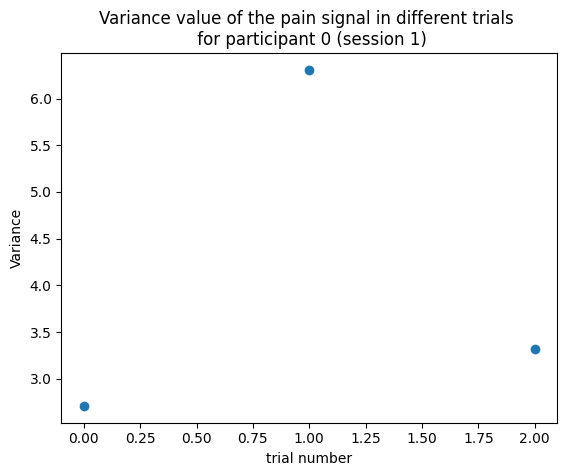

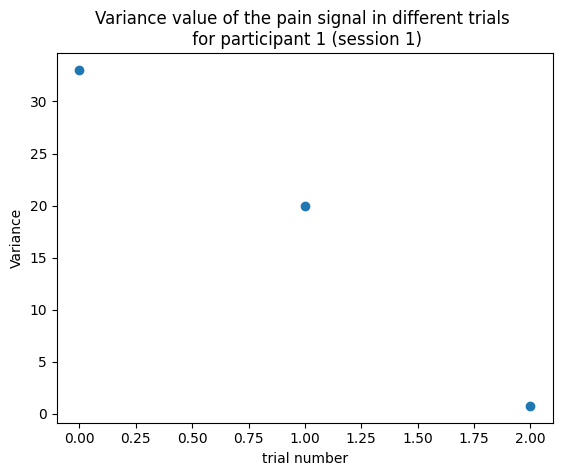

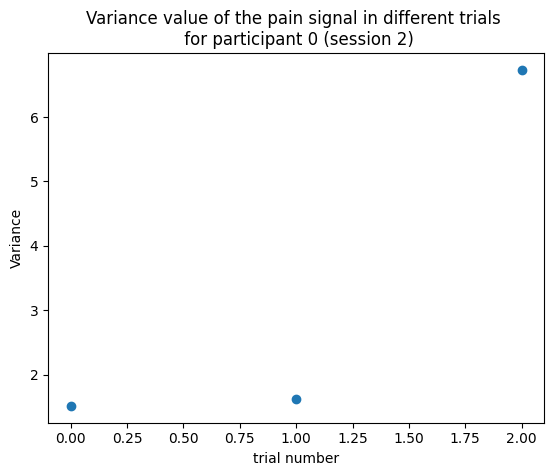

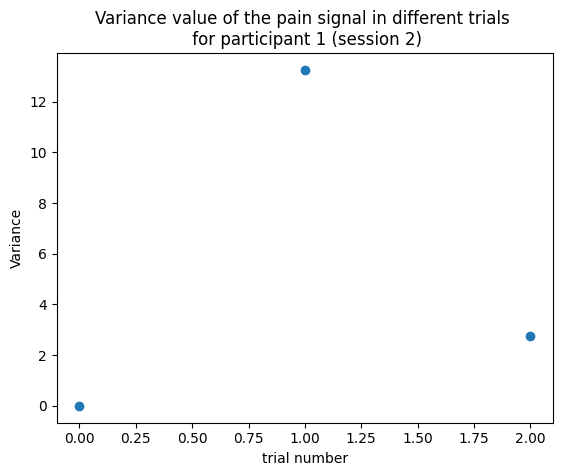

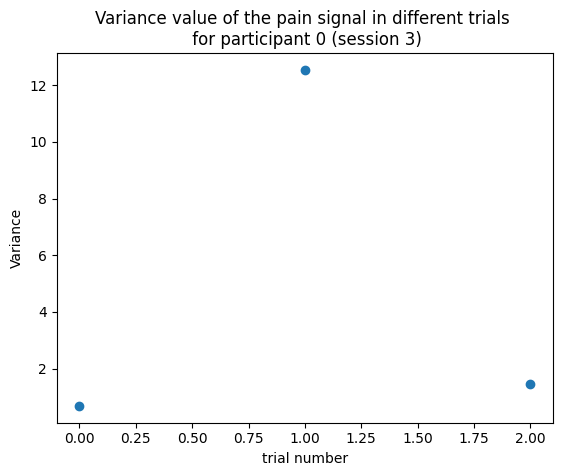

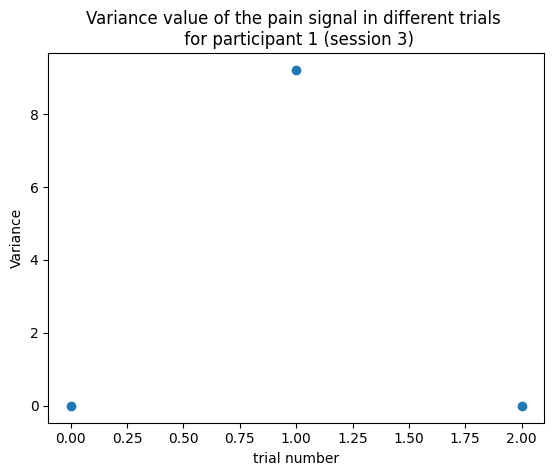

In [50]:
for session in sessions:
    for i in retained_participants_list[session]:
        plt.figure()
        plt.scatter(range(len(variance_list_all[session][i])), variance_list_all[session][i])
        plt.xlabel('trial number')
        plt.ylabel('Variance')
        plt.title(f'Variance value of the pain signal in different trials \n for participant {participant_number[session][i]} (session {session+1})')

## Frequency
### FFT

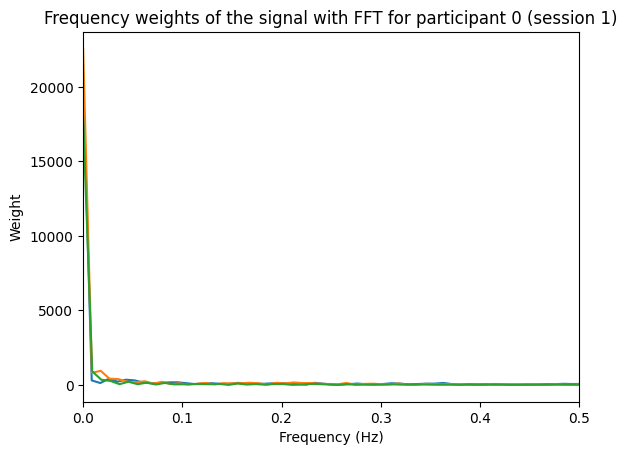

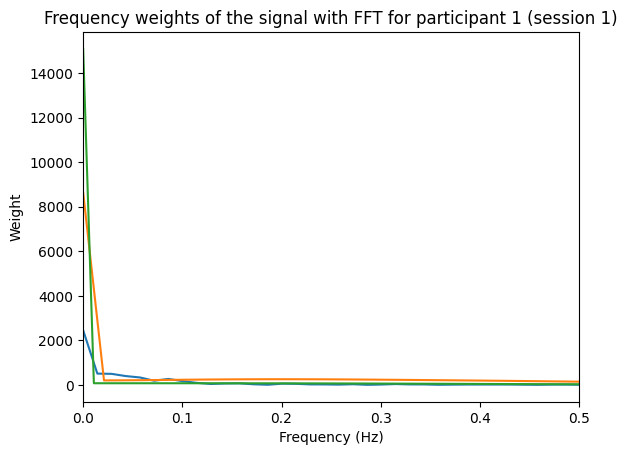

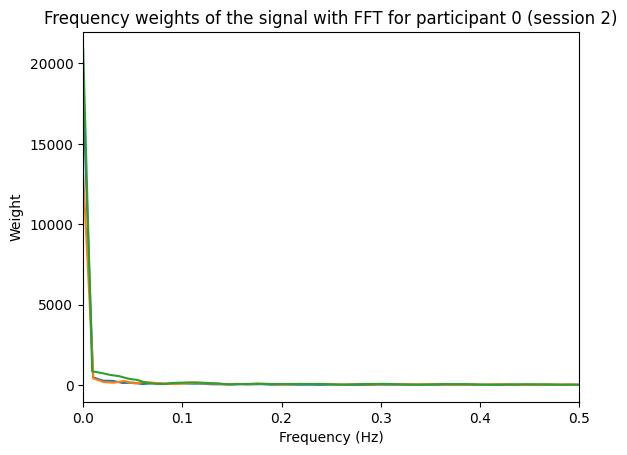

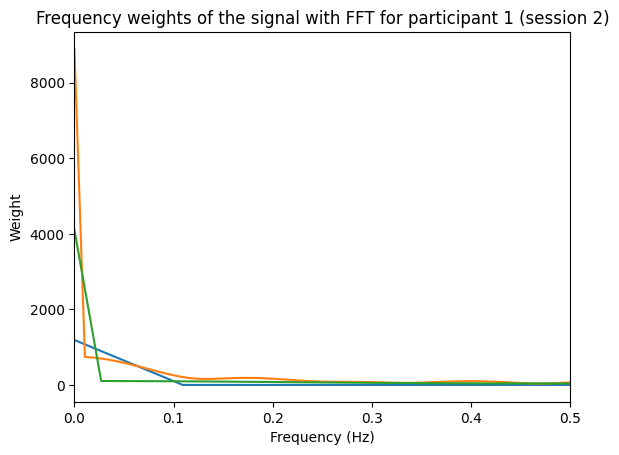

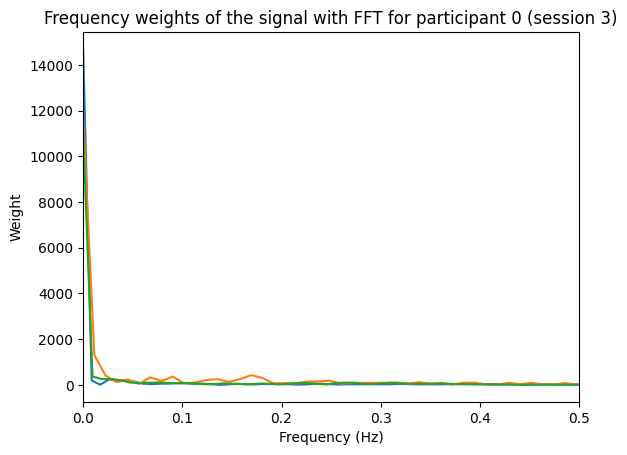

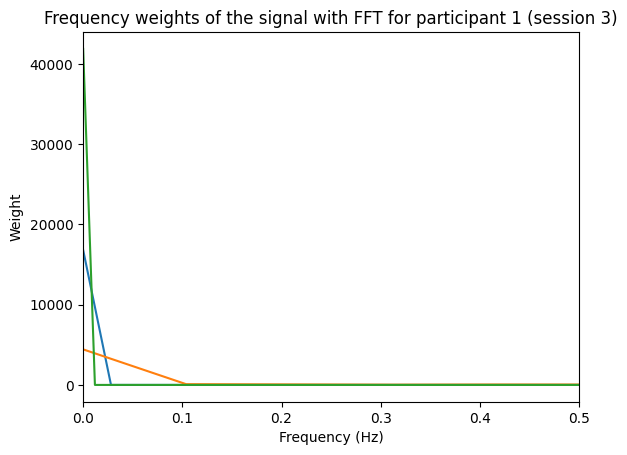

In [51]:
fft_weights_list_all = []
fft_freq_list_all = []
for session in sessions:
    fft_weights_list_session = []
    fft_freq_list_session = []
    for j in retained_participants_list[session]:
        plt.figure()
        fft_weights_list, fft_freq_list = fft_data(lowpass_list_all[session][j], time_windowed_list_all[session][j])
        fft_weights_list_session.append(fft_weights_list)
        fft_freq_list_session.append(fft_freq_list)
        for i in range(len(lowpass_list_all[session][j])):
            plt.plot(fft_freq_list[i], np.abs(fft_weights_list[i]))
        plt.xlim(0,0.5)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Weight')
        plt.title(f'Frequency weights of the signal with FFT for participant {participant_number[session][j]} (session {session + 1})')
    fft_weights_list_all.append(fft_weights_list_session)
    fft_freq_list_all.append(fft_freq_list_session)


### Power spectrum

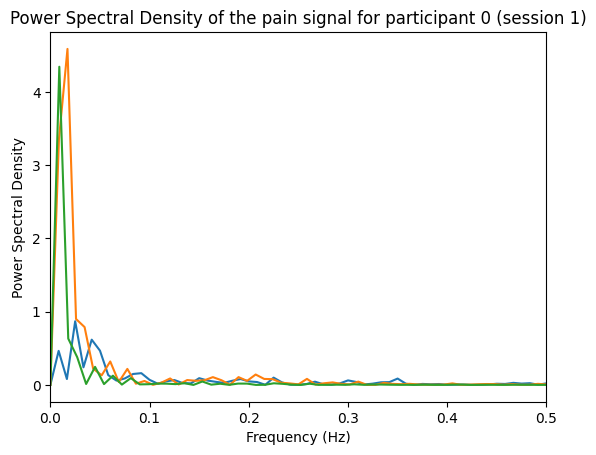

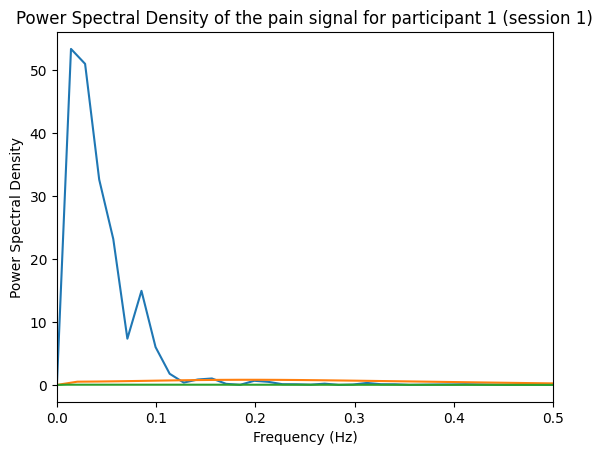

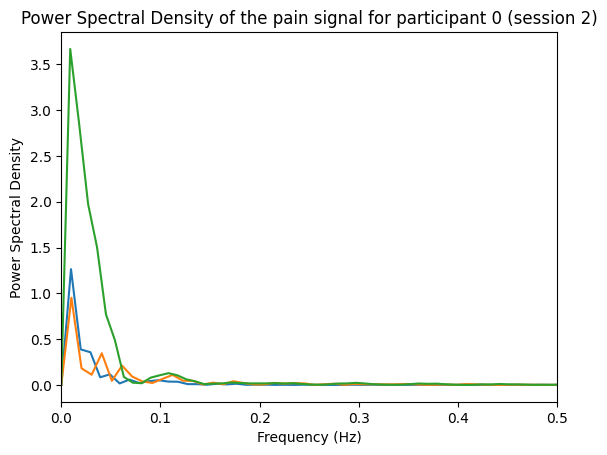

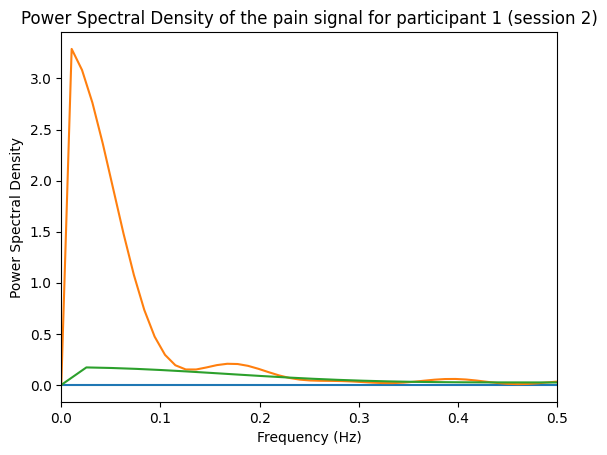

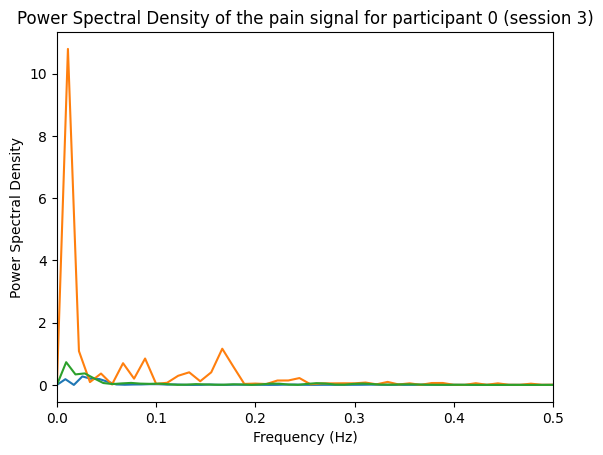

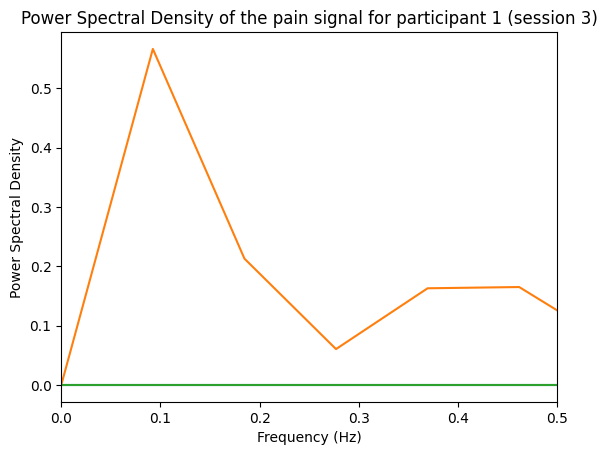

In [52]:
psd_freq_list_all = []
psd_list_all=[]
for session in sessions:
    psd_freq_list_session = []
    psd_list_session = []
    for j in retained_participants_list[session]:
        plt.figure()
        psd_freq_list, psd_list = power_spectrum(lowpass_list_all[session][j], time_windowed_list_all[session][j])
        psd_freq_list_session.append(psd_freq_list)
        psd_list_session.append(psd_list)
        for i in range(len(lowpass_list_all[session][j])):
            plt.plot(psd_freq_list[i], np.abs(psd_list[i]))
        plt.xlim(0,0.5)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Spectral Density')
        plt.title(f'Power Spectral Density of the pain signal for participant {participant_number[session][j]} (session {session+1})')

## Permutation entropy

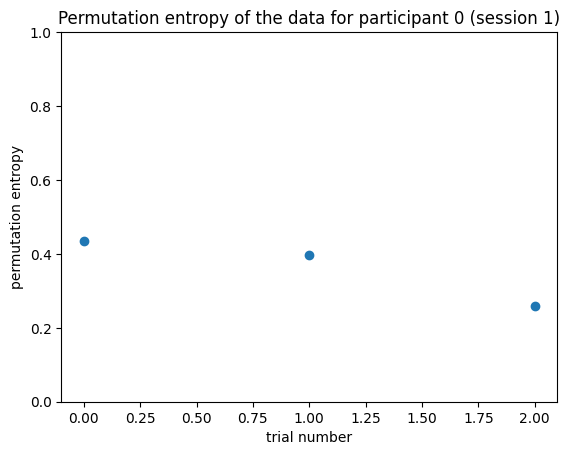

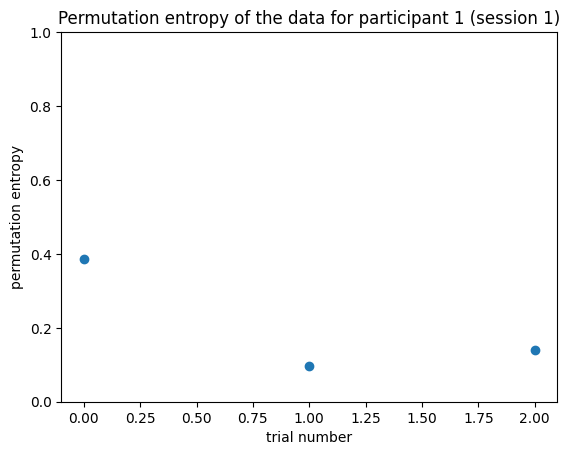

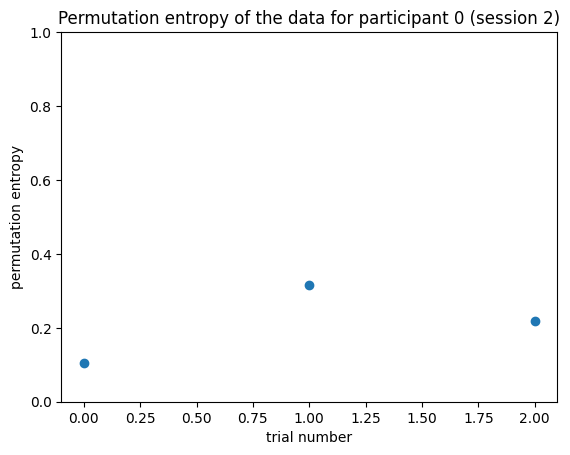

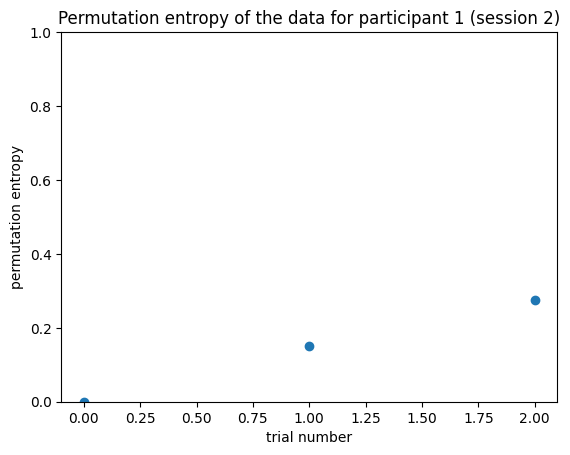

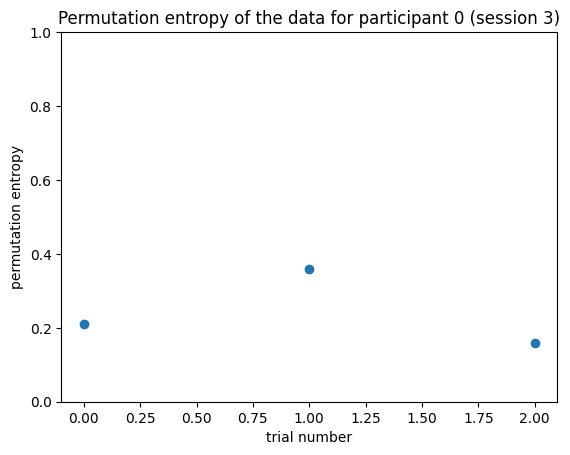

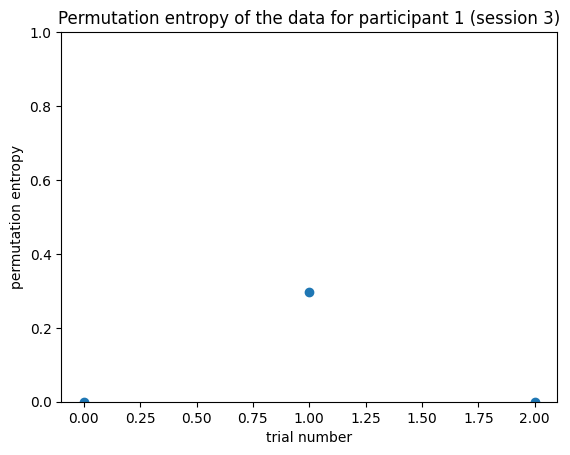

In [53]:
entropy_list_all = []
stat_complexity_list_all = []
for session in sessions:
    entropy_list_session = []
    stat_complexity_list_session = []
    for i in retained_participants_list[session]:
        plt.figure()
        entropy_list, stat_complexity_list = permutation_entropy(lowpass_list_all[session][i])
        entropy_list_session.append(entropy_list)
        stat_complexity_list_session.append(stat_complexity_list)
        plt.scatter(range(len(entropy_list)), entropy_list)
        plt.title(f'Permutation entropy of the data for participant {participant_number[session][i]} (session {session+1})')
        plt.xlabel('trial number')
        plt.ylabel('permutation entropy')
        plt.ylim(-0.1,1.1)
    entropy_list_all.append(entropy_list_session)
    stat_complexity_list_all.append(stat_complexity_list_session)

## Autocorrelation

c:\Users\sharonho\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


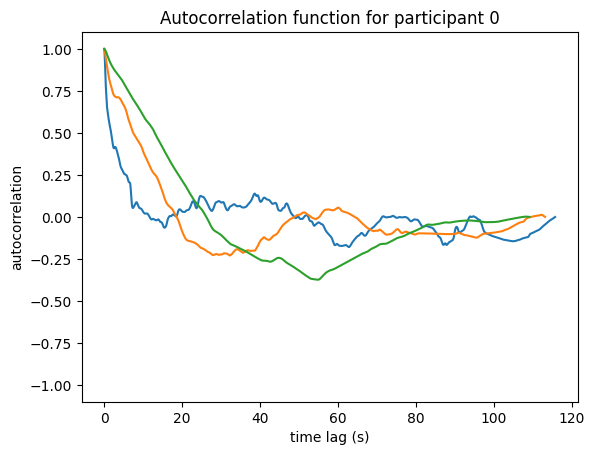

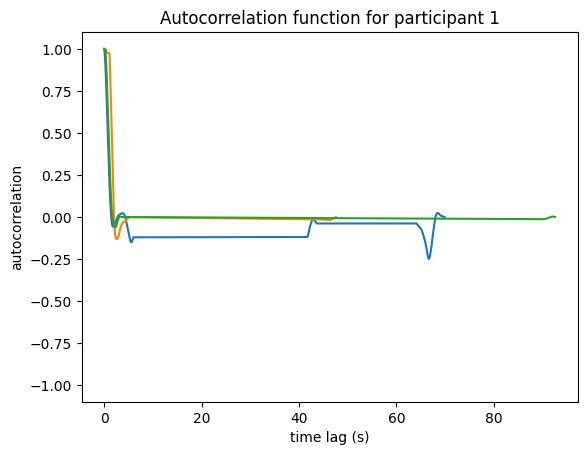

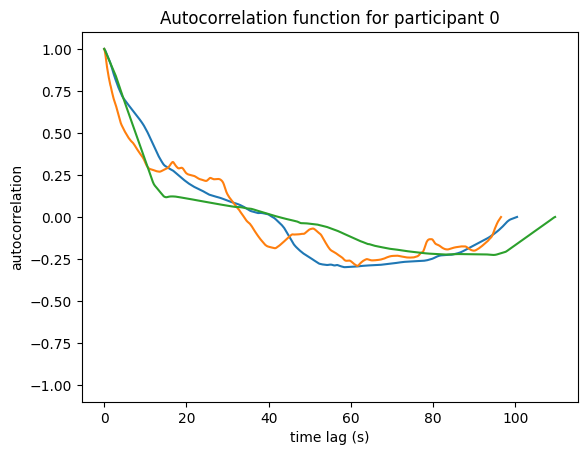

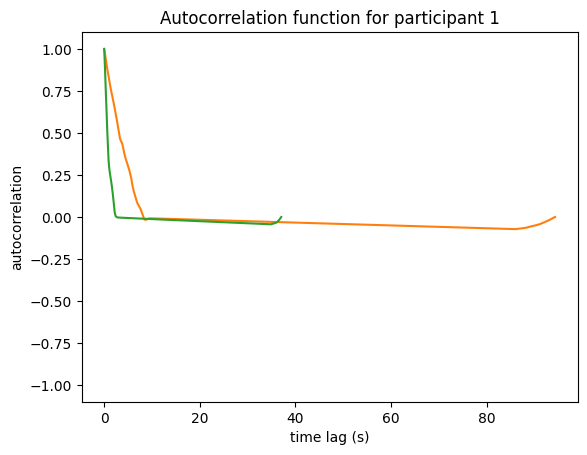

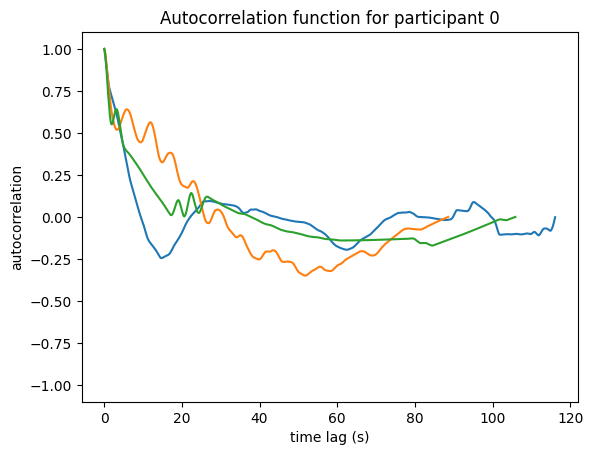

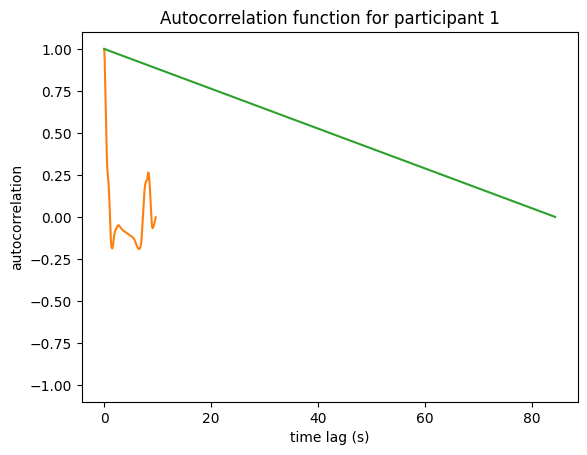

In [54]:
acorr_list_all = []
for session in sessions:
    acorr_list_session = []
    for j in retained_participants_list[session]:
        plt.figure()
        acorr_list = autocorrelation(lowpass_list_all[session][j])
        acorr_list_session.append(acorr_list)

        for i in range(len(time_windowed_list_all[session][j])):
            if len(time_windowed_list_all[session][j][i]) > 1:
                time_lag = np.array(time_windowed_list_all[session][j][i]) - np.array(time_windowed_list_all[session][j][i][0])
                plt.plot(time_lag, acorr_list[i])
        plt.xlabel('time lag (s)')
        plt.ylabel('autocorrelation')
        plt.title(f'Autocorrelation function for participant {j}')
        plt.ylim(-1.1,1.1)
    acorr_list_all.append(acorr_list_session)

## Check stationarity

In [55]:
adfuller_list_all = []
stationary_list_all = []
for session in sessions:
    adfuller_list_session = []
    stationary_list_session = []
    for j in retained_participants_list[session]:
        adfuller_list, labels, stationary_list = adfuller_test(lowpass_list_all[session][j])
        adfuller_list_session.append(adfuller_list)
        stationary_list_session.append(stationary_list)
    adfuller_list_all.append(adfuller_list_session)
    stationary_list_all.append(stationary_list_session)


c:\Users\sharonho\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\sharonho\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\sharonho\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


## Analysing the response of prediction and confidence

In [120]:
prediction_all = []
confidence_all= []
for session in sessions:
    
    prediction_session = []
    confidence_session = []
    for index in range(len(files[session])):   
        #plt.figure()
        data = pd.read_csv(files[session][index])
        if pd.isnull(data['pain_predict_slider.response']).all() == True:
                prediction_session.append(np.nan)
        for j in range(len(data)):
        #obtain relevant data
            if pd.isnull(data['pain_predict_slider.response'].iloc[j]):
                pass
            else:
                prediction = 10*data['pain_predict_slider.response'].iloc[j]
                prediction_session.append(prediction)
        if pd.isnull(data['confidence_slider_2.response']).all() == True:
                confidence_session.append(np.nan)
        for j in range(len(data)):
        #obtain relevant data
            if pd.isnull(data['confidence_slider_2.response'].iloc[j]):
                pass
            else:
                confidence = 10*data['confidence_slider_2.response'].iloc[j]
                confidence_session.append(confidence)
    prediction_all.append(prediction_session)
    confidence_all.append(confidence_session)





In [121]:
prediction_all
#confidence_all
#participant_number
confidence_all

[[6.4709911799999995, 7.710818489999999],
 [5.5293549099999995, 1.99344023],
 [5.73175532, 6.626926279999999]]

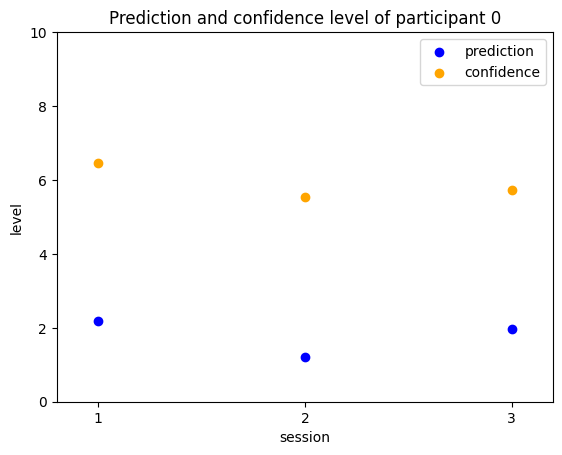

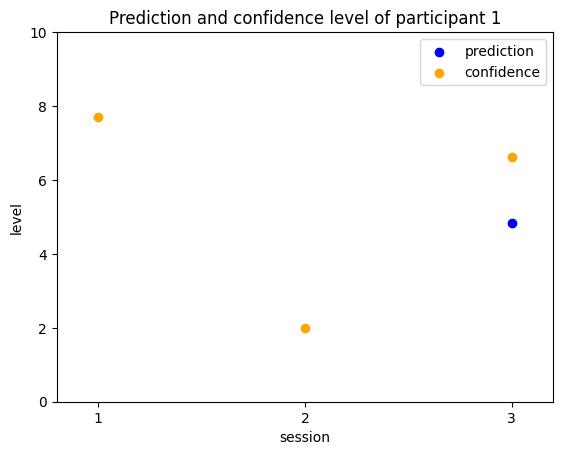

In [128]:
for index in participant_number[0]:
    plt.figure()
    for session in sessions:
    
        plt.scatter(session+1, prediction_all[session][index], c = 'blue')
        plt.scatter(session+1, confidence_all[session][index], c = 'orange')
        plt.xlim(0.8,3.2)
        plt.xticks([1,2,3])
        plt.ylim(0,10)
        plt.title(f'Prediction and confidence level of participant {participant_number[session][index]}')
        plt.xlabel('session')
        plt.ylabel('level')
    plt.legend(['prediction', 'confidence'])

In [132]:
#find the overall mean in one session
mean_overall = []
for session in sessions:
    mean_session = []
    for index in participant_number[session]:
        mean_session.append(np.mean(mean_list_all[session][index]))
    mean_overall.append(mean_session)

mean_overall


[[3.019399930327051, 2.929488721860967],
 [2.811868347918152, 1.860686815915251],
 [2.01617708306545, 7.930590974441984]]

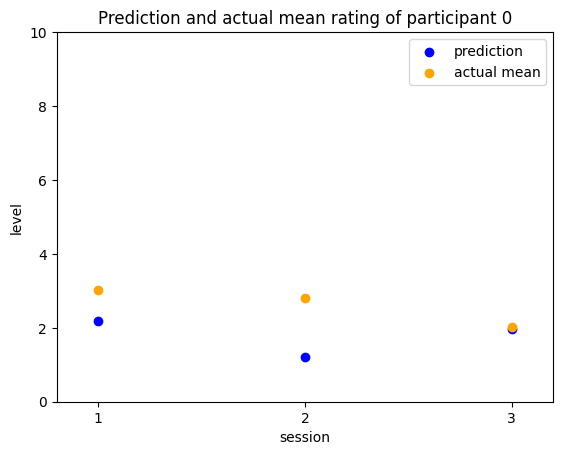

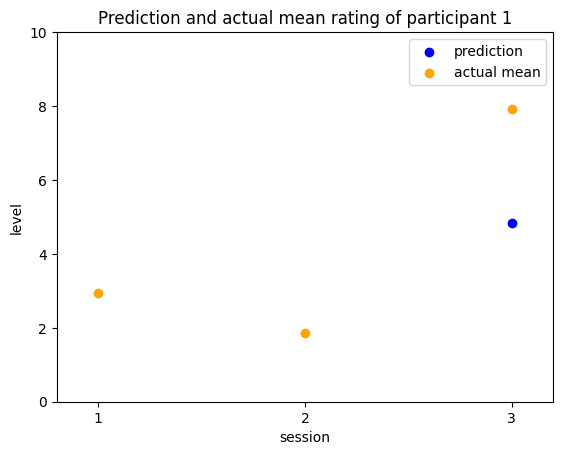

In [193]:
for index in participant_number[0]:
    plt.figure()
    for session in sessions:
    
        plt.scatter(session+1, prediction_all[session][index], c = 'blue')
        plt.scatter(session+1, mean_overall[session][index], c = 'orange')
        plt.xlim(0.8,3.2)
        plt.xticks([1,2,3])
        plt.ylim(0,10)
        plt.title(f'Prediction and actual mean rating of participant {participant_number[session][index]}')
        plt.xlabel('session')
        plt.ylabel('level')
    plt.legend(['prediction', 'actual mean'])

In [77]:
session = 0
index = 1
pd.isnull(pd.read_csv(files[session][index])['pain_predict_slider.response']).all()

True

# Looking at clinical outcomes

In [181]:
files_questionnaire = []
onlyfiles = [f for f in listdir('../Data/clinical_questionnaire') if isfile(join('../Data/clinical_questionnaire', f))]
for i in range(len(onlyfiles)):
    path = '../Data/clinical_questionnaire/' + onlyfiles[i]
    files_questionnaire.append(path)

In [182]:
files_questionnaire

['../Data/clinical_questionnaire/Pain Monitoring Session 1 Questionnaire_March 4, 2023_15.32.csv',
 '../Data/clinical_questionnaire/Pain Monitoring Session 2 Questionnaire_March 4, 2023_15.31.csv']

In [190]:
retained_questionnaire_1 = []
data_1 = pd.read_csv(files_questionnaire[0])
data_1 = data_1.drop(['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
       'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude',
       'DistributionChannel', 'UserLanguage',], axis=1)
new_header = data_1.iloc[0] #grab the first row for the header
data_1 = data_1[1:] #take the data less the header row
data_1.columns = new_header #set the header row as the df header
for id in participant_id_first:
    for j in range(len(data_1)):
        if data_1['PROLIFIC_PID'].iloc[j] == id:
            retained_questionnaire_1.append(j)
questionnaire_1 = data_1.iloc[retained_questionnaire_1]
questionnaire_1 = questionnaire_1.set_index("PROLIFIC_PID")
questionnaire_1

,"Throughout our lives, most of us have had pain from time to time (such as minor headaches, sprains and toothaches). Have you had pain other than these everyday kinds of pain today?","If you feel any pain in your body, please describe below the body part or parts where you feel pain most frequently (e.g. 'left shoulder', 'forehead', 'right knee')",Please rate your pain by choosing the one number that best describes your pain at its WORST in the last 24 hours,Please rate your pain by choosing one number that best describes your pain at\r\nits LEAST in the last 24 hours,Please rate your pain by choosing one number that best describes your pain\r\non the AVERAGE,Please rate your pain by choosing the one number that tells how much pain\r\nyou have RIGHT NOW,"What kinds of things make your pain feel better (for example, heat, medicine, rest)?","What kinds of things make your pain feel worse (for example, walking, standing, lifting)?",What treatments or medications are you receiving for your pain?,"In the last 24 hours, how much relief have pain treatments or medications provided? Please choose the one percentage that shows how much RELIEF you\r\nhave received",...,This question provides you with a list of words that describe some of the\r\ndifferent qualities of pain and related symptoms. Please choose the numbers that best describe the intensity of the pain you may be experiencing at this time. - Punishing-cruel,1. My back pain has spread down my leg(s) at some time in the last 2 weeks,2. I have had pain in the shoulder or neck at some time in the last 2 weeks,3. I have only walked short distances because of my back pain,"4. In the last 2 weeks, I have dressed more slowly than usual because of back pain",5. It’s not really safe for a person with a condition like mine to be physically active,6. Worrying thoughts have been going through my mind a lot of the time,7. I feel that my back pain is terrible and it’s never going to get any better,"8. In general, I have not enjoyed all the things I used to enjoy","9. Overall, how bothersome has your back pain been in the last 2 weeks?"
PROLIFIC_PID,,,,,,,,,,,,,,,,,,,,,
5bc5f36b8d83e10001724601,Yes,Feet. Both feet have arthritis also in my neck...,7,3,5,5,Medication heat rest physical support,"Weight bearing, staying in one postion",Morphine gabepentin amytriptline,60,...,1 mild,Agree,Agree,Agree,Agree,Disagree,Disagree,Agree,Disagree,Moderately
610ce0a48fc7e68abc4070c1,Yes,"back , waist , knee",6,2,3,2,"medicine , oniments","sitting , laying on my back",painkillers,60,...,0 none,Agree,Disagree,Disagree,Disagree,Disagree,Disagree,Agree,Agree,Very much


In [191]:
retained_questionnaire_2 = []
data_2 = pd.read_csv(files_questionnaire[1])
data_2 = data_2.drop(['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
       'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude',
       'DistributionChannel', 'UserLanguage',], axis=1)
new_header = data_2.iloc[0] #grab the first row for the header
data_2 = data_2[1:] #take the data less the header row
data_2.columns = new_header #set the header row as the df header
for id in participant_id_first:
    for j in range(len(data_2)):
        if data_2['PROLIFIC_PID'].iloc[j] == id:
            retained_questionnaire_2.append(j)
questionnaire_2 = data_2.iloc[retained_questionnaire_2]

questionnaire_2 = questionnaire_2.set_index("PROLIFIC_PID")
questionnaire_2

,"Listed below are thirteen statements describing different thoughts and feelings that may be associated with pain. Using the following scale, please indicate the degree to which you have these thoughts and feelings when you are experiencing pain.\n\n 0 = not at all, 1 = to a slight degree, 2 = to a moderate degree, 3 = to a great degree, 4 = all the time - 1. I worry all the time about whether the pain will end.","Listed below are thirteen statements describing different thoughts and feelings that may be associated with pain. Using the following scale, please indicate the degree to which you have these thoughts and feelings when you are experiencing pain.\n\n 0 = not at all, 1 = to a slight degree, 2 = to a moderate degree, 3 = to a great degree, 4 = all the time - 2. I feel I can't go on.","Listed below are thirteen statements describing different thoughts and feelings that may be associated with pain. Using the following scale, please indicate the degree to which you have these thoughts and feelings when you are experiencing pain.\n\n 0 = not at all, 1 = to a slight degree, 2 = to a moderate degree, 3 = to a great degree, 4 = all the time - 3. It's terrible and I think it's never going to get any better.","Listed below are thirteen statements describing different thoughts and feelings that may be associated with pain. Using the following scale, please indicate the degree to which you have these thoughts and feelings when you are experiencing pain.\n\n 0 = not at all, 1 = to a slight degree, 2 = to a moderate degree, 3 = to a great degree, 4 = all the time - 4. It's awful and I feel that it overwhelms me.","Listed below are thirteen statements describing different thoughts and feelings that may be associated with pain. Using the following scale, please indicate the degree to which you have these thoughts and feelings when you are experiencing pain.\n\n 0 = not at all, 1 = to a slight degree, 2 = to a moderate degree, 3 = to a great degree, 4 = all the time - 5. I feel I can't stand it anymore.","Listed below are thirteen statements describing different thoughts and feelings that may be associated with pain. Using the following scale, please indicate the degree to which you have these thoughts and feelings when you are experiencing pain.\n\n 0 = not at all, 1 = to a slight degree, 2 = to a moderate degree, 3 = to a great degree, 4 = all the time - 6. I become afraid that the pain will get worse.","Listed below are thirteen statements describing different thoughts and feelings that may be associated with pain. Using the following scale, please indicate the degree to which you have these thoughts and feelings when you are experiencing pain.\n\n 0 = not at all, 1 = to a slight degree, 2 = to a moderate degree, 3 = to a great degree, 4 = all the time - 7. I keep thinking of other painful events.","Listed below are thirteen statements describing different thoughts and feelings that may be associated with pain. Using the following scale, please indicate the degree to which you have these thoughts and feelings when you are experiencing pain.\n\n 0 = not at all, 1 = to a slight degree, 2 = to a moderate degree, 3 = to a great degree, 4 = all the time - 8. I anxiously want the pain to go away.","Listed below are thirteen statements describing different thoughts and feelings that may be associated with pain. Using the following scale, please indicate the degree to which you have these thoughts and feelings when you are experiencing pain.\n\n 0 = not at all, 1 = to a slight degree, 2 = to a moderate degree, 3 = to a great degree, 4 = all the time - 9. I can't seem to keep it out of my mind.","Listed below are thirteen statements describing different thoughts and feelings that may be associated with pain. Using the following scale, please indicate the degree to which you have these thoughts and feelings when you are experiencing pain.\n\n 0 = not at all, 1 = to a slight degree, 2 = to a moderate degree, 3 = to a great degree, 4 = all the

In [192]:
questionnaires_merged = questionnaire_1.join(questionnaire_2)
questionnaires_merged

,"Throughout our lives, most of us have had pain from time to time (such as minor headaches, sprains and toothaches). Have you had pain other than these everyday kinds of pain today?","If you feel any pain in your body, please describe below the body part or parts where you feel pain most frequently (e.g. 'left shoulder', 'forehead', 'right knee')",Please rate your pain by choosing the one number that best describes your pain at its WORST in the last 24 hours,Please rate your pain by choosing one number that best describes your pain at\r\nits LEAST in the last 24 hours,Please rate your pain by choosing one number that best describes your pain\r\non the AVERAGE,Please rate your pain by choosing the one number that tells how much pain\r\nyou have RIGHT NOW,"What kinds of things make your pain feel better (for example, heat, medicine, rest)?","What kinds of things make your pain feel worse (for example, walking, standing, lifting)?",What treatments or medications are you receiving for your pain?,"In the last 24 hours, how much relief have pain treatments or medications provided? Please choose the one percentage that shows how much RELIEF you\r\nhave received",...,"Over the last 2 weeks, how often have you been bothered by any of the following problems? - Becoming easily annoyed or irritable?","Over the last 2 weeks, how often have you been bothered by any of the following problems? - Feeling afraid as if something awful might happen?","Over the last two weeks, how often have you been bothered by any of the following problems? - Little interest or pleasure in doing things?","Over the last two weeks, how often have you been bothered by any of the following problems? - Feeling down, depressed, or hopeless?","Over the last two weeks, how often have you been bothered by any of the following problems? - Trouble falling or staying asleep, or sleeping too much?","Over the last two weeks, how often have you been bothered by any of the following problems? - Feeling tired or having little energy?","Over the last two weeks, how often have you been bothered by any of the following problems? - Poor appetite or overeating?","Over the last two weeks, how often have you been bothered by any of the following problems? - Feeling bad about yourself - or that you are a failure or have let yourself or your family down?","Over the last two weeks, how often have you been bothered by any of the following problems? - Trouble concentrating on things, such as reading the newspaper or watching television?","Over the last two weeks, how often have you been bothered by any of the following problems? - Moving or speaking so slowly that other people could have noticed? Or the opposite - being so fidgety or restless that you have been moving around a lot more than usual?"
PROLIFIC_PID,,,,,,,,,,,,,,,,,,,,,
5bc5f36b8d83e10001724601,Yes,Feet. Both feet have arthritis also in my neck...,7,3,5,5,Medication heat rest physical support,"Weight bearing, staying in one postion",Morphine gabepentin amytriptline,60,...,Not at all,Not at all,Not at all,Not at all,Nearly every day,Nearly every day,Nearly every day,Several days,Several days,Not at all
610ce0a48fc7e68abc4070c1,Yes,"back , waist , knee",6,2,3,2,"medicine , oniments","sitting , laying on my back",painkillers,60,...,Several days,Several days,Several days,Several days,More than half the days,Several days,Several days,More than half the days,Several days,Not at all


o	Evaluate difference between the PE values statistically

o	Pearson’s correlation coefficient to test the relationship between the PE values and pain levels?
